# PREDICTION

In [1]:
import os
import sklearn.metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import scipy.io as sio
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2


Using TensorFlow backend.


In [5]:
#os.mkdir('./processed_testing_features')
#os.mkdir('./preds_folder')

In [2]:
def classifier_model():
    """Build the classifier
    :returns: Classifier model
    :rtype: keras.Model
    """
    model = Sequential()
    model.add(Dense(512, input_dim=4096, kernel_initializer='glorot_normal',
                    kernel_regularizer=l2(0.001), activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(32, kernel_initializer='glorot_normal',
                    kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))
    model.add(Dense(1, kernel_initializer='glorot_normal',
                    kernel_regularizer=l2(0.001), activation='sigmoid'))
    return model


# build classifier and load pretrained weights
def create_classifier_model():
    model = classifier_model()
    model = load_weights(model, './weights_new.mat')
    return model



In [3]:
def load_weights(model, weights_file):
    """Loads the pretrained weights into the network architecture
    :param model: keras model of the network
    :param weights_file: Path to the weights file
    :returns: The input model with the weights properly loaded
    :rtype: keras.model
    """
    dict2 = sio.loadmat(weights_file)
    dict = conv_dict(dict2)
    i = 0
    for layer in model.layers:
        weights = dict[str(i)]
        layer.set_weights(weights)
        i += 1
    return model

def conv_dict(dict2):
    """Prepare the dictionary of weights to be loaded by the network
    :param dict2: Dictionary to format
    :returns: The dictionary properly formatted
    :rtype: dict
    """
    dict = {}
    for i in range(len(dict2)):
        if str(i) in dict2:
            if dict2[str(i)].shape == (0, 0):
                dict[str(i)] = dict2[str(i)]
            else:
                weights = dict2[str(i)][0]
                weights2 = []
                for weight in weights:
                    if weight.shape in [(1, x) for x in range(0, 5000)]:
                        weights2.append(weight[0])
                    else:
                        weights2.append(weight)
                dict[str(i)] = weights2
    return dict

In [4]:
def load_test_set(videos_path, videos_list):
    feats = []
    
    for vid in videos_list:
        vid_path = os.path.join(videos_path, vid)
        with open(vid_path, "rb") as f:
            feat = np.load(f)
        feats.append(feat)

    feats = np.array(feats)
    return feats

classifier_model = create_classifier_model()

vid_list = os.listdir('./processed_test_features')
vid_list.sort()

test_set = load_test_set('./processed_test_features', vid_list)

for filename, example in zip(vid_list, test_set):
    predictions_file = filename[:-4] + '.npy'
    pred_path = os.path.join('./preds_folder', predictions_file)
    pred = classifier_model.predict_on_batch(example)
    with open(pred_path, "wb") as f:
        np.save(pred_path, pred, allow_pickle=True)

# EVALUATION

In [5]:
def extrapolate(outputs, num_frames):
    """Expand output to match the video length
    :param outputs: Array of predicted outputs
    :param num_frames: Expected size of the output array
    :returns: Array of output size
    :rtype: np.ndarray
    """

    extrapolated_outputs = []
    extrapolation_indices = np.round(np.linspace(0, len(outputs) - 1, num=num_frames))
    for index in extrapolation_indices:
        extrapolated_outputs.append(outputs[int(index)])
    return np.array(extrapolated_outputs)



In [6]:
annotations_path = './input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Temporal_Anomaly_Annotation_for_Testing_Videos.txt'

In [7]:
frame_height = 240
frame_width = 320
channels = 3

frame_count = 16

features_per_bag = 32

In [8]:
def sliding_window(arr, size, stride):
    """Apply sliding window to an array, getting chunks of
    of specified size using the specified stride
    :param arr: Array to be divided
    :param size: Size of the chunks
    :param stride: Number of frames to skip for the next chunk
    :returns: Tensor with the resulting chunks
    :rtype: np.ndarray
    """
    num_chunks = int((len(arr) - size) / stride) + 2
    result = []
    for i in range(0,  num_chunks * stride, stride):
        if len(arr[i:i + size]) > 0:
            result.append(arr[i:i + size])
    return np.array(result)


def interpolate(features, features_per_bag):
    """Transform a bag with an arbitrary number of features into a bag
    with a fixed amount, using interpolation of consecutive features
    :param features: Bag of features to pad
    :param features_per_bag: Number of features to obtain
    :returns: Interpolated features
    :rtype: np.ndarray
    """
    feature_size = np.array(features).shape[1]
    interpolated_features = np.zeros((features_per_bag, feature_size))
    interpolation_indices = np.round(np.linspace(0, len(features) - 1, num=features_per_bag + 1))
    count = 0
    for index in range(0, len(interpolation_indices)-1):
        start = int(interpolation_indices[index])
        end = int(interpolation_indices[index + 1])

        assert end >= start

        if start == end:
            temp_vect = features[start, :]
        else:
            temp_vect = np.mean(features[start:end+1, :], axis=0)

        temp_vect = temp_vect / np.linalg.norm(temp_vect)

        if np.linalg.norm(temp_vect) == 0:
            print("Error")

        interpolated_features[count,:]=temp_vect
        count = count + 1

    return np.array(interpolated_features)


def extrapolate(outputs, num_frames):
    """Expand output to match the video length
    :param outputs: Array of predicted outputs
    :param num_frames: Expected size of the output array
    :returns: Array of output size
    :rtype: np.ndarray
    """

    extrapolated_outputs = []
    extrapolation_indices = np.round(np.linspace(0, len(outputs) - 1, num=num_frames))
    for index in extrapolation_indices:
        extrapolated_outputs.append(outputs[int(index)])
    return np.array(extrapolated_outputs)



In [9]:
import cv2

def get_video_frames(video_path):
    """Reads the video given a file path
    :param video_path: Path to the video
    :returns: Video as an array of frames
    :rtype: np.ndarray
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        else:
            break
    cap.release()
    return frames

def get_video_clips(video_path):
    """Divides the input video into non-overlapping clips
    :param video_path: Path to the video
    :returns: Array with the fragments of video
    :rtype: np.ndarray
    """
    frames = get_video_frames(video_path)
    clips = sliding_window(frames, frame_count, frame_count)
    return clips, len(frames)


In [10]:
ground_truth = pd.read_csv(
    annotations_path, header=None, sep="\s+", index_col=0,
    names=['Type', 'Start1', 'End1', 'Start2', 'End2']
)



In [11]:
frames_list = []
for idx, row in ground_truth.iterrows():
    video_file_path = os.path.join('./Testing_Normal_Videos_Anomaly', idx)
    _, frames = get_video_clips(video_file_path)
    frames_list.append(frames)

#print(frames_list)
ground_truth['Frames'] = frames_list
ground_truth.to_csv("trial.csv", header=False)
ground_truth.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


,Type,Start1,End1,Start2,End2,Frames
Abuse028_x264.mp4,Abuse,165,240,-1,-1,1412
Abuse030_x264.mp4,Abuse,1275,1360,-1,-1,1544
Arrest001_x264.mp4,Arrest,1185,1485,-1,-1,2374
Arrest007_x264.mp4,Arrest,1530,2160,-1,-1,3144
Arrest024_x264.mp4,Arrest,1005,3105,-1,-1,3629


In [12]:
output_folder ='./'

Accuracy: 0.73218, AUC: 0.75868, F1: 0.31517, EER: 0.28487, AP: 0.20999
Confusion matrix
[[516937 177834]
 [ 28630  47510]]


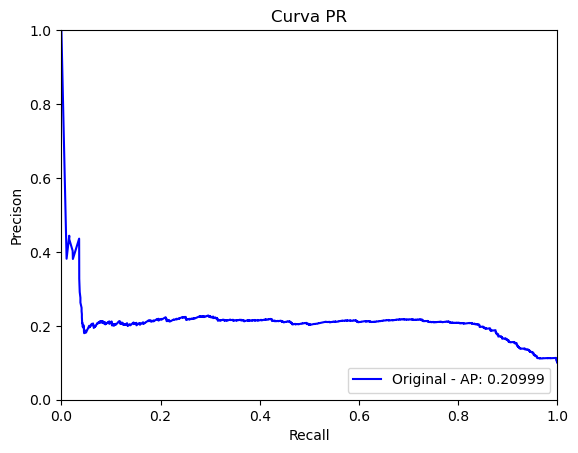

In [13]:
def eer_score(fpr, tpr, thr):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    fnr = 1-tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((fpr[min_index], fnr[min_index]))
    return eer, thr[min_index]
preds = []
gts = []
for idx, row in ground_truth.iterrows():
    preds_file_path = os.path.join('./preds_folder', idx[:-9] + ".npy")
    frames = row[5]
    try:
        with open(preds_file_path, "rb") as f:
            curr_preds = np.load(f)

        padded_preds = extrapolate(curr_preds, frames)
    except FileNotFoundError:
        padded_preds = np.zeros((frames,1))
        print("No predictions generated for {}".format(idx))

    curr_gts = np.zeros(frames)
    anomaly_start_1 =  row[1]
    anomaly_end_1 = row[2]

    anomaly_start_2 =  row[3]
    anomaly_end_2 = row[4]

    if anomaly_start_1 != -1 and anomaly_end_1 != -1:
        curr_gts[anomaly_start_1:anomaly_end_1+1] = 1

    if anomaly_start_2 != -1 and anomaly_end_2 != -1:
        curr_gts[anomaly_start_2:anomaly_end_2+1] = 1

    preds.append(padded_preds)
    gts.append(curr_gts)

gts = np.concatenate(gts)
preds = np.concatenate(preds)
preds_labels = np.round(preds)

acc = sklearn.metrics.accuracy_score(gts, preds_labels)
ap = sklearn.metrics.average_precision_score(gts, preds)
f1 = sklearn.metrics.f1_score(gts, preds_labels)
fpr, tpr, thr = sklearn.metrics.roc_curve(gts, preds)
prec, rec, _ = sklearn.metrics.precision_recall_curve(gts, preds)
eer, _ = eer_score(fpr, tpr, thr)
conf_mat = sklearn.metrics.confusion_matrix(gts, preds_labels)
auc = sklearn.metrics.auc(fpr, tpr)

plt.title("Curva ROC")
plt.plot(fpr, tpr, 'b', label = "AUC: {}".format(auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(output_folder, "roc.png"))

plt.clf()

plt.title("Curva PR")
plt.plot(rec, prec, 'b', label = "Original - AP: {:.5f}".format(ap))
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precison')
plt.xlabel('Recall')
plt.savefig(os.path.join(output_folder, "pr_curve.png"))

print("Accuracy: {:.5f}, AUC: {:.5f}, F1: {:.5f}, EER: {:.5f}, AP: {:.5F}".format(
    acc, auc, f1, eer, ap
))

print("Confusion matrix")
print(conf_mat)